# Imports

In [1]:
#!pip install tensorflow
#!pip install opencv-python
#!pip install cv2
# !pip install BIRDS
# pip install --upgrade --user pip
# !pip install google.colab
# !pip install itables
# !pip install dill
# !pip install visualkeras
# !pip install pydot


In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
import json
# import birds_utils.BIRDS
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau,History,CSVLogger


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model

# System libraries
from pathlib import Path
import os.path
import random
import pickle
# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
import birds_utils as birds
sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import dill
import copy

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import ImageFont
import visualkeras
import time



## Import helping functions

In [3]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# # Import series of helper functions for our notebook
# from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [4]:
# import urllib.request

# url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
# filename = "helper_functions.py"
# urllib.request.urlretrieve(url, filename)

# Run configuration

In [5]:
# principle parameters
BATCH_SIZE = 32 # size of batch (The ImageDataGenerator objects generate batches of tensor image data with real-time data augmentation)
TARGET_SIZE = (224, 224)    # size of pictures (used by the ImageDataGenerator objects)
N_LABELS = 'all'    # number of lables for analysis ('all will keep all labels)
N_EPOCHS = 100 # number of epochs for the traning NN
N_SAMPLES_PER_LABEL = 'all' # number of sampels per label that are kept for valing ('all' will keep all samples)
N_EPOCHS_PATIENCE = 20
AUGMENTATON = False
BASE_PATH = './models/'
GRID_SEARCH = True  
RANDOM_STATE = 50

if (AUGMENTATON):
    RUN_NAME = f'birds_augmentation_N_LABELS_{N_LABELS}'
else:
    RUN_NAME = f'birds_no_augmentation_N_LABELS_{N_LABELS}'
label_count_thresh = 50
fig_width = 8

MODELS_PATH = f'{BASE_PATH}{RUN_NAME}/'
if (not os.path.exists(MODELS_PATH)):
    os.makedirs(MODELS_PATH)



# Load and prepare data

## load data

In [6]:
project_dir = '.'
image_df_full = birds.load_data(project_dir).drop_duplicates() 
image_df_full = image_df_full.sample(frac=1, random_state=RANDOM_STATE)  # frac=1 means the entire DataFrame is sampled



## EDA

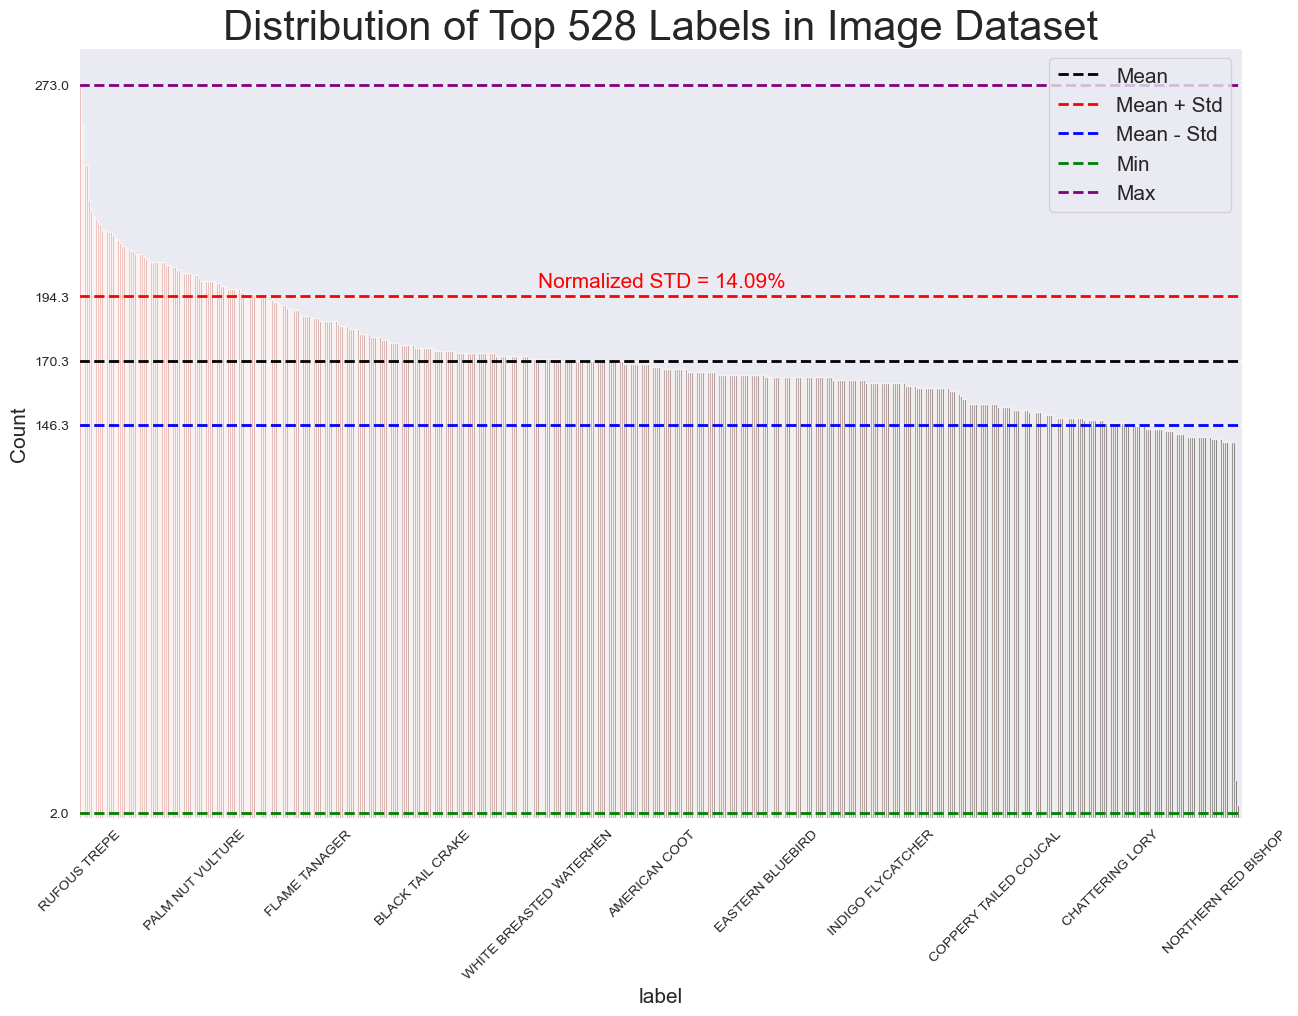

In [7]:
birds.plot_labels_count(image_df_full)

In [8]:
# filter out all the lables with less than label_count_thresh
boolean_vec = image_df_full.groupby('label').count()['Filepath'].values>=label_count_thresh
labels_to_keep = image_df_full.groupby('label').count()[boolean_vec]
image_df = birds.filter_df(image_df_full,labels=list(labels_to_keep.index))
# remove 'other' images
image_df = birds.remove_other_images(image_df)



In [9]:
if (N_LABELS=='all'):
    N_LABELS = len(birds.get_labels(image_df))
    
lables = list(birds.get_labels(image_df)[0:N_LABELS])
image_df = birds.filter_df(image_df,labels=lables)
image_df = birds.filter_df(image_df,N_samples_per_label=N_SAMPLES_PER_LABEL)

from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
labels = image_df['label'].tolist() # Make sure this is your training data labels
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))


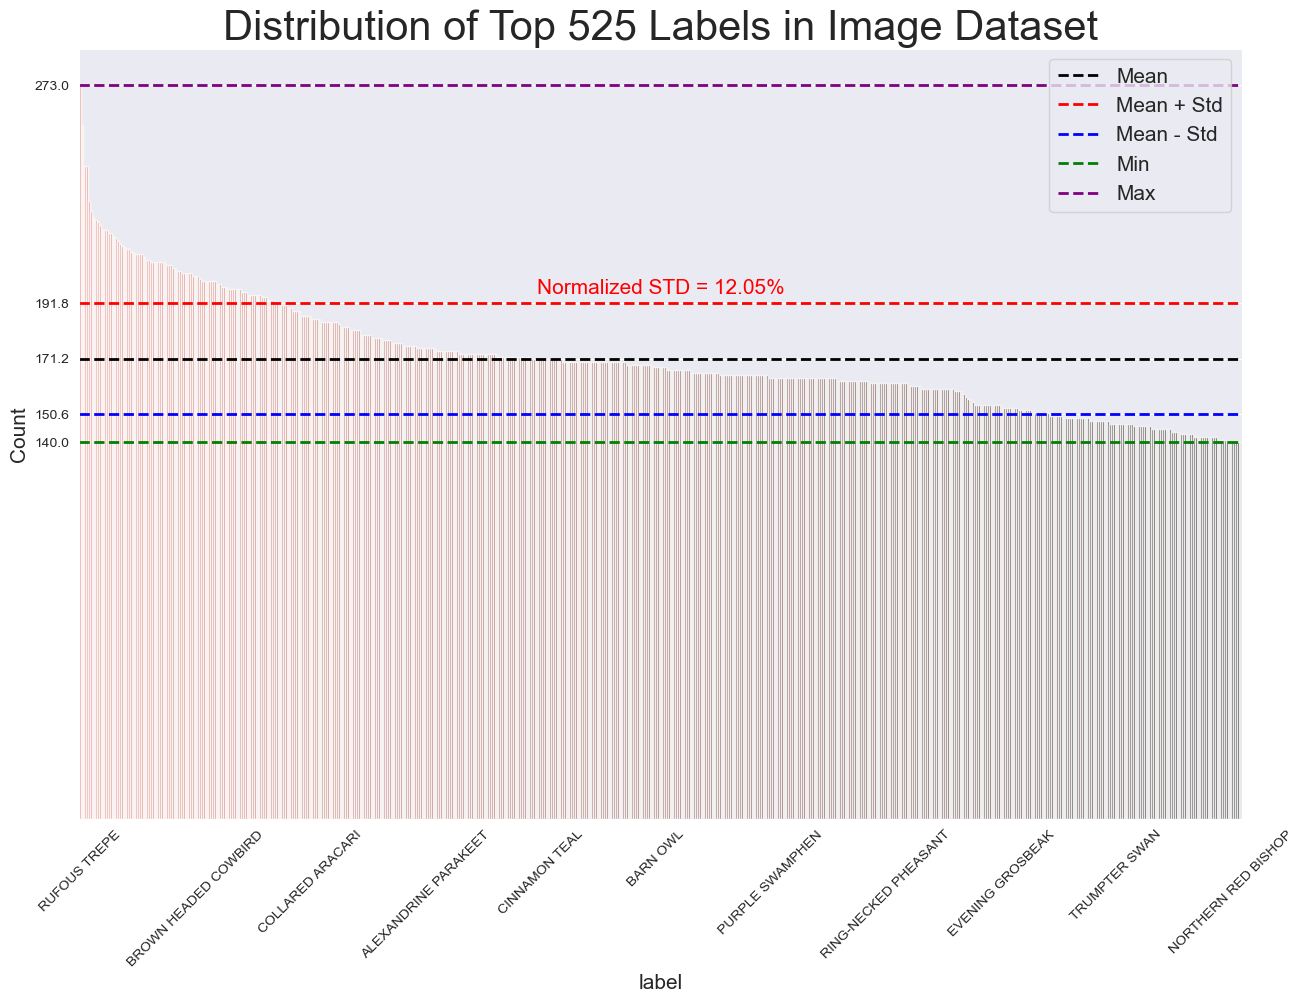

In [10]:
# birds.test_df
# plot all images of a label
# # plot the 1'st 5 instances of a labelbirds.plot_label_images(test_df,label=birds.get_labels(test_df)[1])

# birds.plot_label_images(test_df,label=birds.get_labels(test_df)[1],N=5)

# # plot tests according to idx
# birds.plot_label_tests(test_df,idx=[1,9])

birds.plot_labels_count(image_df)

# Data Splitting into 3 ImageDataGenerators


In [11]:
# Separate in train and test data
train_obj_dic = {'name':'train'}
val_obj_dic = {'name':'val'}
test_obj_dic = {'name':'test'}

# we saw that the df was balanced so we added stratify=image_df['label']

train_df_pre, test_obj_dic['df'] = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=RANDOM_STATE,stratify=image_df['label'])
train_obj_dic['df'], val_obj_dic['df'] = train_test_split(train_df_pre, test_size=0.2, shuffle=True, random_state=RANDOM_STATE,stratify=train_df_pre['label'])



In [12]:
images_obj_params = {}
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

# we keep the paramters separately in order to retrive the objects after saving (see )
# Dictionary of parameters
images_obj_params['train'] = {
    'dataframe': train_obj_dic['df'],
    'x_col': 'Filepath',
    'y_col': 'label',
    'target_size': TARGET_SIZE,
    'color_mode': 'rgb',
    'class_mode': 'categorical',
    'batch_size': BATCH_SIZE,
    'shuffle': False,
    'seed': RANDOM_STATE,
}

# Creating a new generator using dictionary unpacking
train_obj_dic['images_obj'] = train_generator.flow_from_dataframe(**images_obj_params['train'])
train_obj_dic['images_obj_params'] = images_obj_params['train']


val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

# Dictionary of parameters
images_obj_params['val'] = {
    'dataframe': val_obj_dic['df'],
    'x_col': 'Filepath',
    'y_col': 'label',
    'target_size': TARGET_SIZE,
    'color_mode': 'rgb',
    'class_mode': 'categorical',
    'batch_size': BATCH_SIZE,
    'shuffle': False,
    'seed': RANDOM_STATE,
}

# Creating a new generator using dictionary unpacking
val_obj_dic['images_obj'] = val_generator.flow_from_dataframe(**images_obj_params['val'])
val_obj_dic['images_obj_params'] = images_obj_params['val']


test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

# Dictionary of parameters
images_obj_params['test'] = {
    'dataframe': test_obj_dic['df'],
    'x_col': 'Filepath',
    'y_col': 'label',
    'target_size': TARGET_SIZE,
    'color_mode': 'rgb',
    'class_mode': 'categorical',
    'batch_size': BATCH_SIZE,
    'shuffle': False,
    'seed': RANDOM_STATE,
}

# Creating a new generator using dictionary unpacking
test_obj_dic['images_obj'] = test_generator.flow_from_dataframe(**images_obj_params['test'])
test_obj_dic['images_obj_params'] = images_obj_params['test']


Found 57523 validated image filenames belonging to 525 classes.
Found 14381 validated image filenames belonging to 525 classes.
Found 17976 validated image filenames belonging to 525 classes.


In [13]:
# craete labels dictionary to be used by apply_model routine
labels_dic = birds.create_lables_dic(train_obj_dic['images_obj'])


## Define the image augmentation object

## Observing augemented images

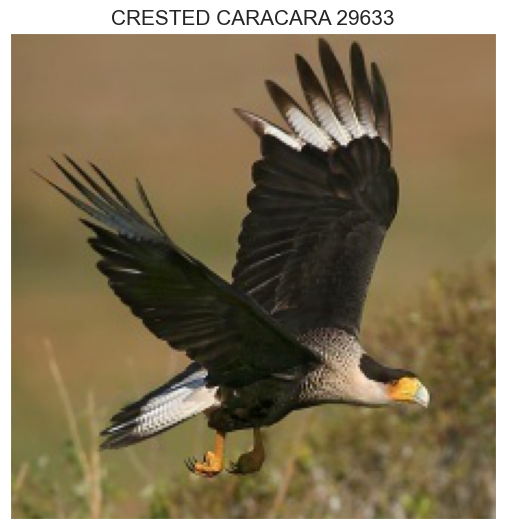

In [14]:
try:
    birds.plot_images(image_df,idx=[29633],n_cols=1,fig_width = 5)

except:
    k =1 

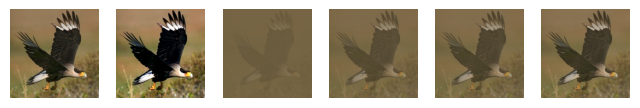

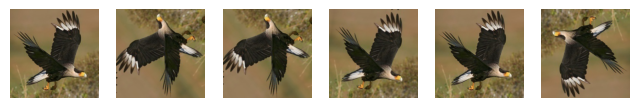

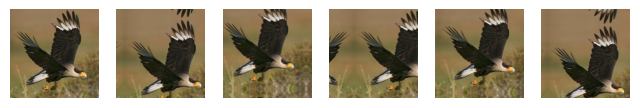

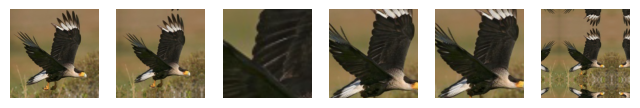

In [15]:
try:
    ind = 3
    img = birds.get_image(image_df,idx=29633)
    import copy


    num_cols=6


    operation_dic = {
                        'RandomContrast':[1.0,1.0],
                        'RandomRotation':[0,180],
                        'RandomTranslation':[0.1,0.5],  
                        'RandomZoom':[0.9,0.9]                   
                    }

    num_rows = len(operation_dic.keys())
    fig_width = 8


    for opration in list(operation_dic.keys()):
        val_vec = np.linspace(operation_dic[opration][0],operation_dic[opration][1],num_cols)
        fig, axes = plt.subplots(1, num_cols, figsize=(fig_width, fig_width*num_rows/num_cols) )
        c=0
        for ind, ax in enumerate(axes.flat):
            img = copy.deepcopy(birds.get_image(image_df[:],idx=29633))
            if (c==0):
                ax.imshow(img)
                ax.axis('off')
                c=1
                continue

            if (opration=='RandomContrast'):
                augment = tf.keras.Sequential([
                    layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows])
                ])
            elif (opration=='RandomRotation'):
                augment = tf.keras.Sequential([
                    # layers.experimental.preprocessing.RandomRotation([val_vec[ind%num_rows],val_vec[ind%num_rows]])
                    layers.experimental.preprocessing.RandomRotation(factor=(0,val_vec[ind%num_rows]))
                ])
                
            elif (opration=='RandomTranslation'):
                augment = tf.keras.Sequential([
                    layers.experimental.preprocessing.RandomTranslation(height_factor = val_vec[ind%num_rows],width_factor = val_vec[ind%num_rows])
                ])

            elif (opration=='RandomZoom'):
                augment = tf.keras.Sequential([
                    layers.experimental.preprocessing.RandomZoom(val_vec[ind%num_rows])
                ])



            # Example: Replace this line with your image loading logic
            img_array = np.expand_dims(img, axis=0)

            augmented_image = augment(np.expand_dims(img, 0)).numpy().squeeze() / 255

            # Display the augmented image in the current subplot
            ax.imshow(augmented_image)
            ax.axis('off')

            # augment = tf.keras.Sequential([
            #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),
            #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),
            #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),
            #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),
            #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),                
            #     ])


        plt.show()

except:
        k = 1


# Model assembly

## Image Augemntation

In [16]:
operation_dic = {
                    'RandomContrast':1.0,
                    'RandomRotation':180,
                    'RandomTranslation':0.5,  
                    'RandomZoom':0.9, 
                    'RandomFlip':'horizontal'                  
                }

if (AUGMENTATON):
  RUN_NAME = f'Translation'

augment = tf.keras.Sequential([
  # layers.experimental.preprocessing.Resizing(224,224),
  # layers.experimental.preprocessing.Rescaling(1./255),
#   layers.experimental.preprocessing.RandomFlip(operation_dic['RandomFlip']),
  # layers.experimental.preprocessing.RandomRotation(operation_dic['RandomRotation']),
  layers.experimental.preprocessing.RandomTranslation(height_factor = operation_dic['RandomTranslation'] ,width_factor = operation_dic['RandomTranslation']),
  # layers.experimental.preprocessing.RandomTranslation(height_factor = val_vec[ind%num_rows],width_factor = val_vec[ind%num_rows])

  # layers.experimental.preprocessing.RandomZoom(operation_dic['RandomZoom']),
#   layers.experimental.preprocessing.RandomContrast(operation_dic['RandomContrast']),
])

## load EfficientNetB0 pre-process NN

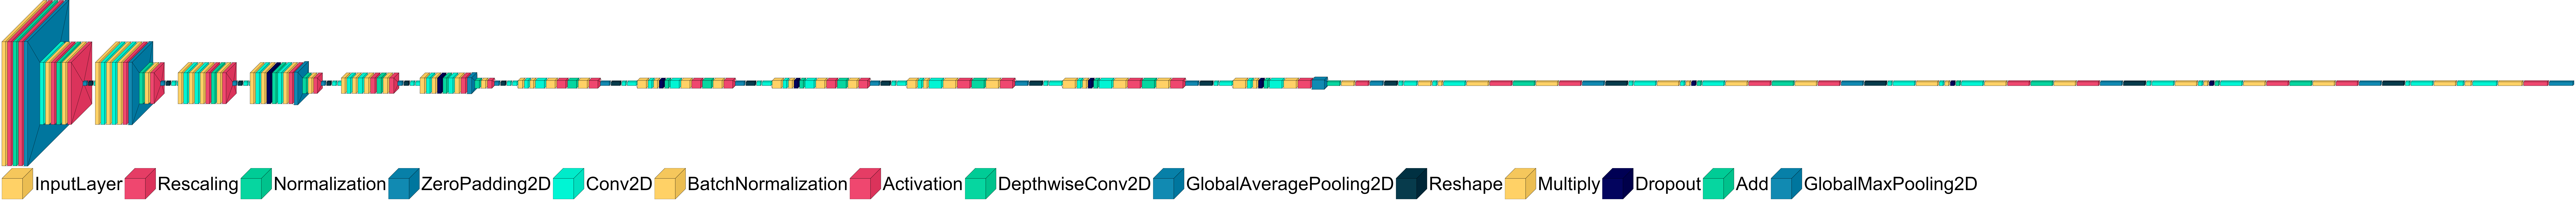

In [17]:
import visualkeras
color_map = birds.create_color_map

# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False
font_size = 100
scale_xy=3

# Adjust the font size
font = ImageFont.truetype("arial.ttf", font_size)


visualkeras.layered_view(pretrained_model, legend=True, font=font, to_file='model.png', scale_xy=scale_xy, color_map=birds.create_color_map())

# Model training 

In [18]:
if (GRID_SEARCH):
    params_dic = {}
    # params_dic['dense1_size'] = [64,128,256]
    # params_dic['dense2_size'] = [64,128,256]
    params_dic['dense1_size'] = [128]
    params_dic['dense2_size'] = [256]
    
    params_dic['N_epochs_patitence'] = [N_EPOCHS_PATIENCE]
    params_dic['N_epochs'] = [N_EPOCHS] 
    params_dic['N_labels'] = [N_LABELS]
    selected_indices = []  # Note: Python indexing is zero-based
    params_list = birds.get_params_permutations(params_dic)

    if (len(selected_indices) == 0):
        selected_permutations = params_list
    else:
        selected_permutations = [params_list[i] for i in selected_indices]

    for i in range(len(selected_permutations)):
        params = selected_permutations[i]
        model = birds.create_model(pretrained_model,params,visualize_model=True,AUGMENTATON = AUGMENTATON)
        model,history = birds.train_model(model,MODELS_PATH,train_obj_dic,val_obj_dic,params)

        # creat (or load) the obj_dic_stack including all data for model performance analysis
        # obj_dic_stack_file_name = f'{MODELS_PATH}obj_dic_stack.pkl'
        obj_dic_stack = birds.get_obj_dic_stack(model,MODELS_PATH,train_obj_dic,val_obj_dic,test_obj_dic,params,plot_report=False)

        # plot score peformance for all 3 datasets
        birds.plot_obj_dic_stack_score(obj_dic_stack,score='f1-score')

else:
    model = birds.create_model(pretrained_model,{},visualize_model=True,AUGMENTATON = AUGMENTATON)
    model,history = birds.train_model(model,MODELS_PATH,train_obj_dic,val_obj_dic,params,run_path=MODELS_PATH)

 

-----------------
  create model
-----------------


NameError: name 'train_model' is not defined

In [ ]:
from birds_utils import create_lables_dic
from birds_utils import apply_model
from birds_utils import create_run_path_name

In [ ]:
obj_dic_stack = birds.get_obj_dic_stack(model,MODELS_PATH,train_obj_dic,val_obj_dic,test_obj_dic,params,plot_report=False)

loding obj_dic_stack from ./models/birds_no_augmentation_N_LABELS_all_128_256_20_100_525//obj_dic_stack.pkl
Found 57523 validated image filenames belonging to 525 classes.
Found 14381 validated image filenames belonging to 525 classes.
Found 17976 validated image filenames belonging to 525 classes.


In [ ]:
# plot_model(model, show_shapes=True, show_layer_names=True)

# Model Evaluation

## compare runs in terms of number of ephocs and performance

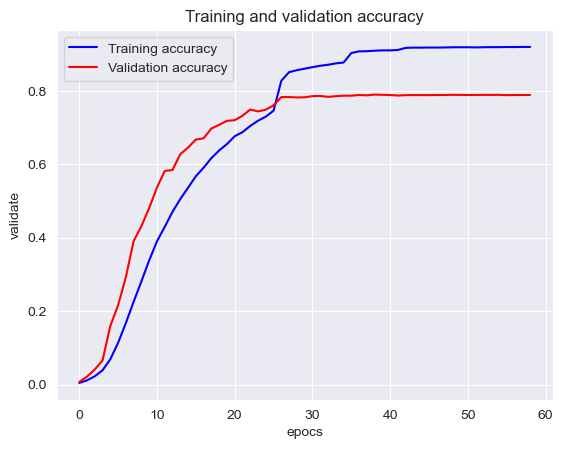

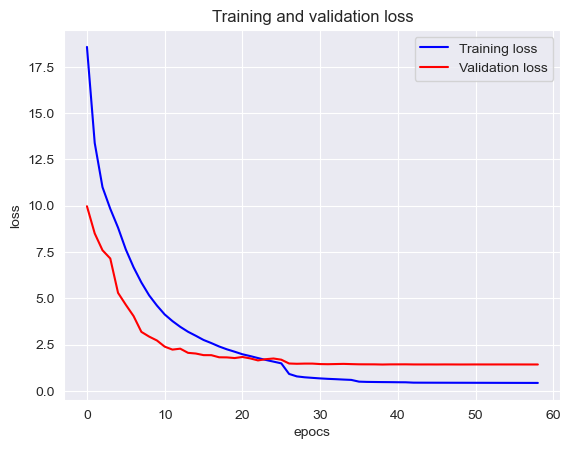

In [ ]:
# get all the history file names in a list

try:
    if (GRID_SEARCH):
        subfolders = birds.get_filtered_subfolders (BASE_PATH,f'LABELS_{N_LABELS}_')
        history_file_names = []
        for subfolder in subfolders:
            file_name = birds.get_filtered_files(BASE_PATH+subfolder,'history',full_path = 'True')
            history_file_names.append(file_name[0])

        if (len(history_file_names)>1):
            birds.plot_training_history(history_file_names)
        else:
            birds.plot_history_single_run(history)

except:
    print('could not plot run history. Possible reason is that no runs for this configuration')


loding obj_dic_stack from ./models/birds_no_augmentation_N_LABELS_all_128_256_20_100_525//obj_dic_stack.pkl
Found 57523 validated image filenames belonging to 525 classes.
Found 14381 validated image filenames belonging to 525 classes.
Found 17976 validated image filenames belonging to 525 classes.


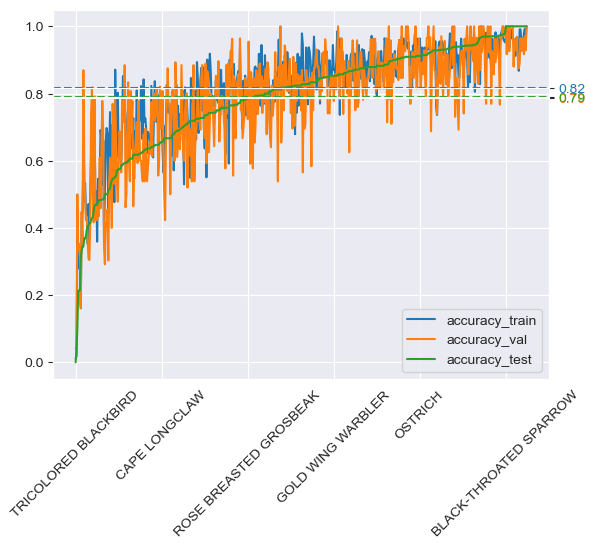

In [ ]:
# creat (or load) the obj_dic_stack including all data for model performance analysis
obj_dic_stack_file_name = f'{MODELS_PATH}{RUN_NAME}_obj_dic_stack.pkl'
obj_dic_stack = birds.get_obj_dic_stack(model,MODELS_PATH,train_obj_dic,val_obj_dic,test_obj_dic,params,plot_report=False)

# plot score peformance for all 3 datasets
birds.plot_obj_dic_stack_score(obj_dic_stack,score='accuracy')


## Check the distribution of the labels in all dfs

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 [Text(-100.0, 0, 'ROSEATE SPOONBILL'),
  Text(0.0, 0, 'ABBOTTS BABBLER'),
  Text(100.0, 0, 'BLUE HERON'),
  Text(200.0, 0, 'EASTERN GOLDEN WEAVER'),
  Text(300.0, 0, 'INDIAN ROLLER'),
  Text(400.0, 0, 'RAZORBILL'),
  Text(500.0, 0, 'VULTURINE GUINEAFOWL'),
  Text(600.0, 0, '')])

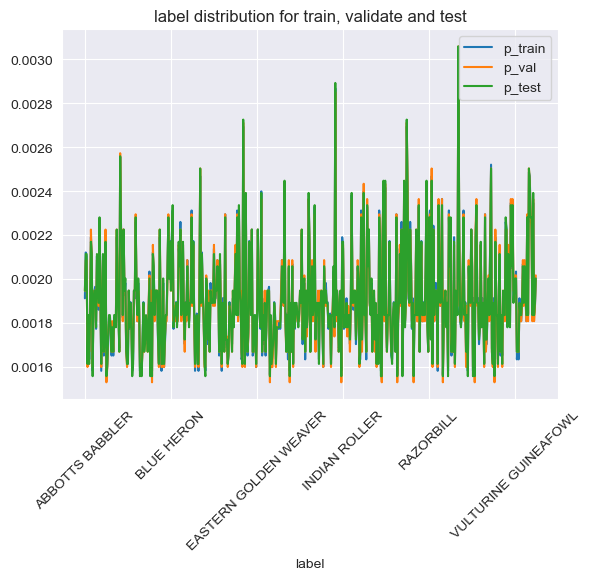

In [ ]:
fig = plt.figure

label_distribute = pd.DataFrame()
label_distribute_pre = pd.DataFrame()
for df_type in obj_dic_stack.keys():
    label_distribute_pre['p'+'_'+df_type] = obj_dic_stack[df_type]['df'].groupby('label').count().status/obj_dic_stack[df_type]['df'].shape[0]
    
    if label_distribute.shape[0]==0:
        label_distribute = label_distribute_pre['p'+'_'+df_type]
    
label_distribute_pre.plot(y=label_distribute_pre.columns)
plt.title('label distribution for train, validate and test')
plt.xticks(rotation=45, fontsize=10)
# plt.xticks(range(0, len(label_distribute_pre.index), max(len(label_distribute_pre.index) // 10, 1)), label_distribute_pre.index[::max(len(label_distribute_pre.index) // 10, 1)])
    


## look at false detections

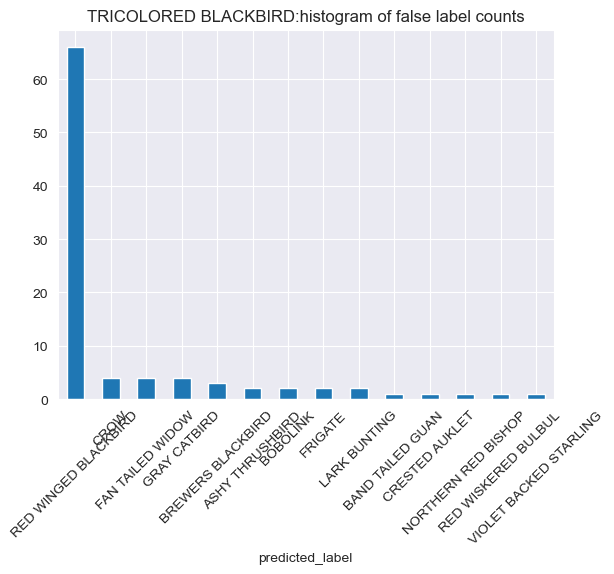

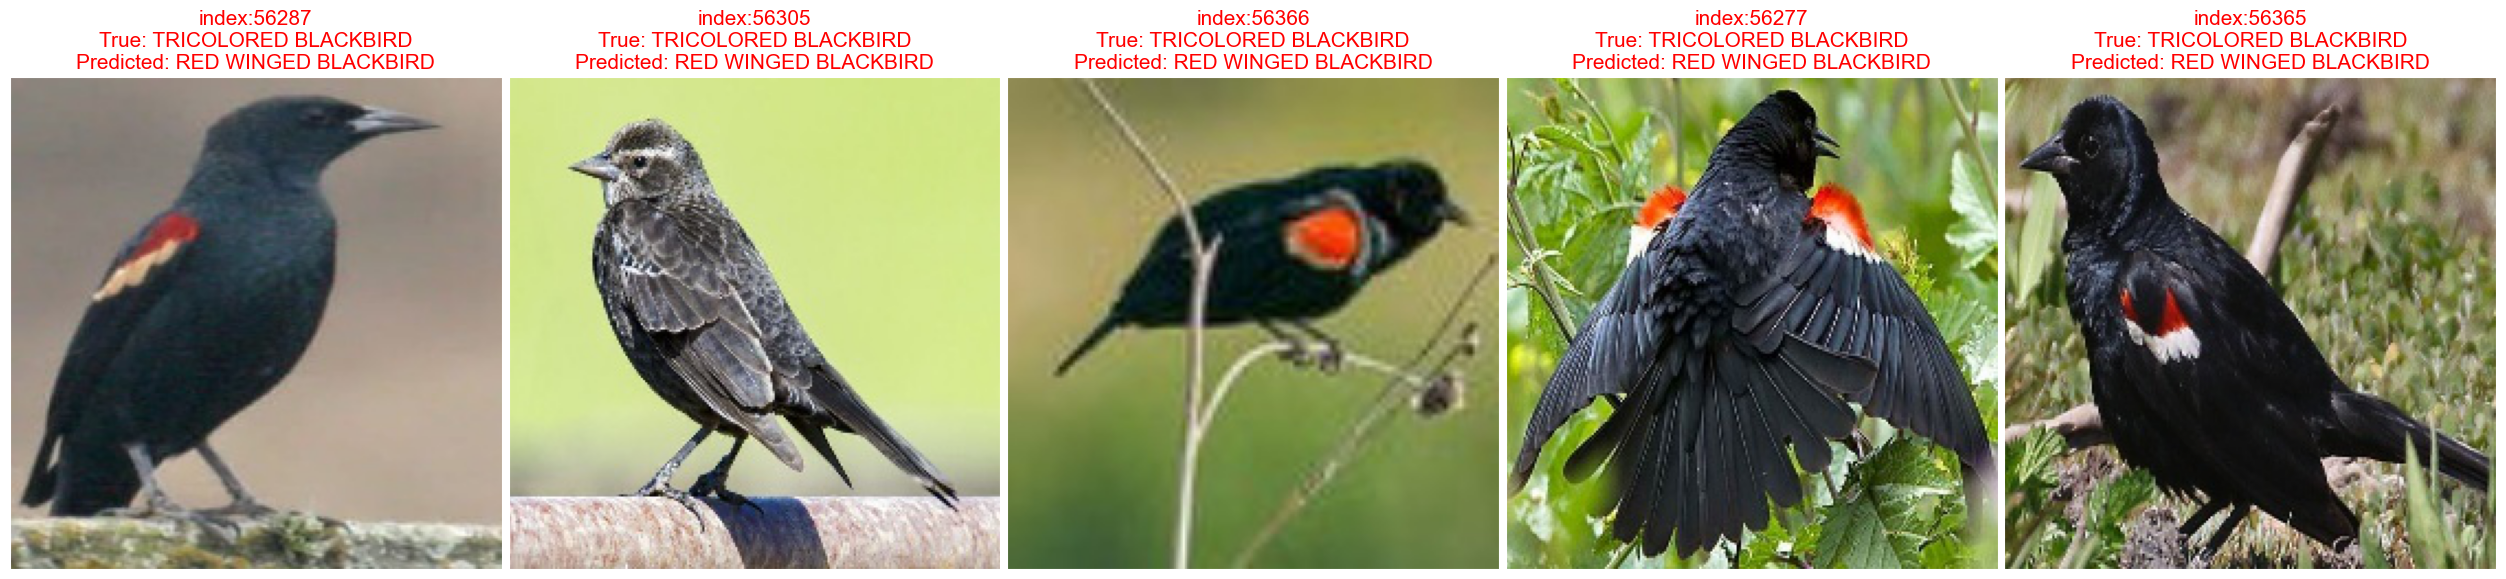

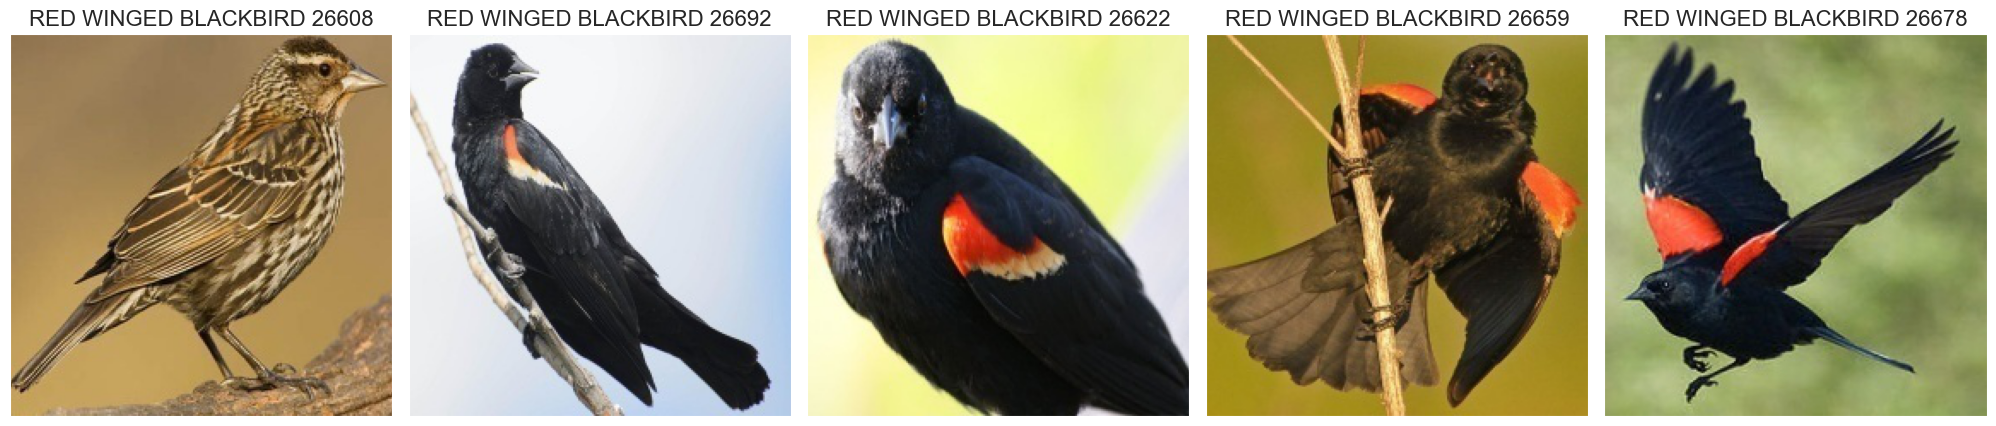

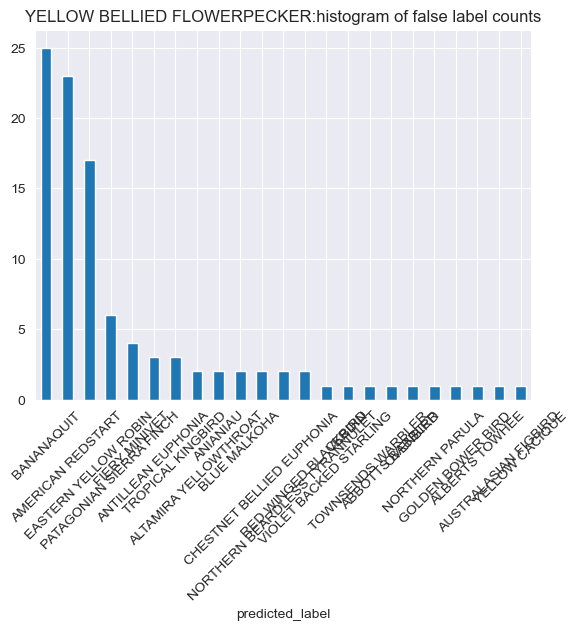

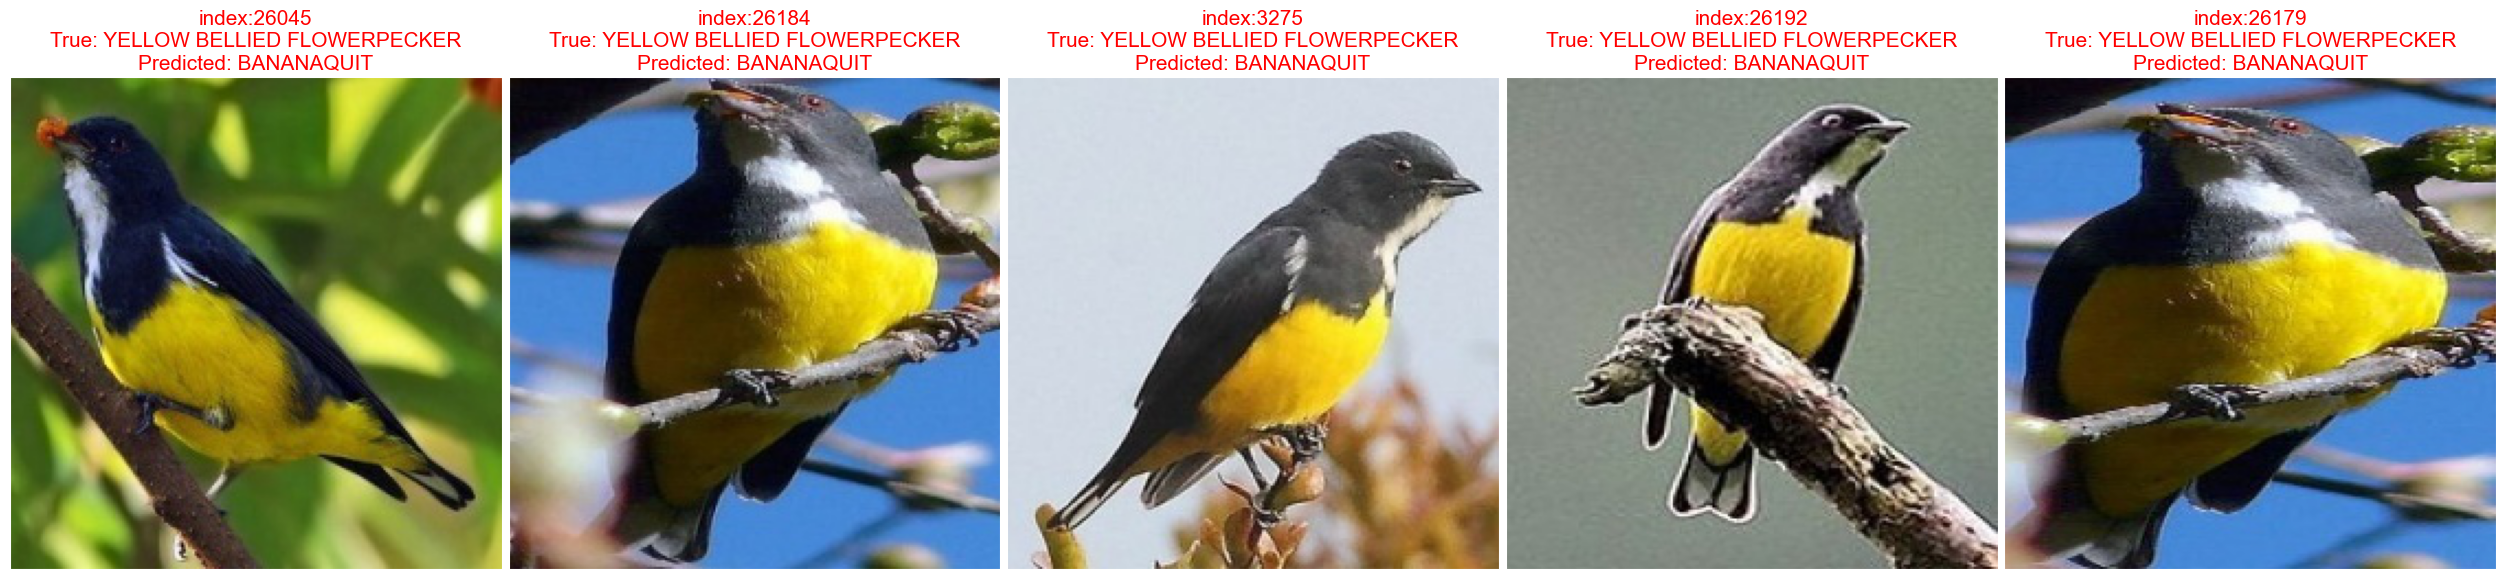

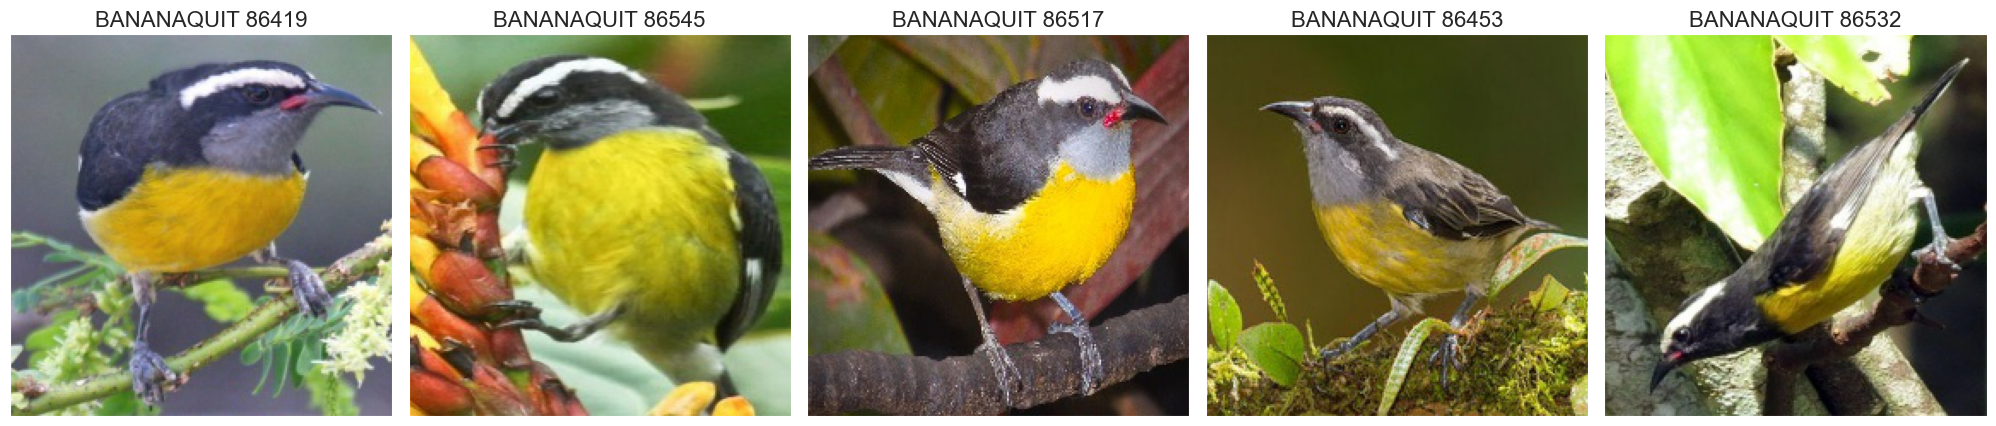

In [ ]:
birds.plot_label_false_and_true(obj_dic_stack,ana_label=None,ana_label_ind=0,n_cols=5,N=5,false_ind=0,false_label = None)
birds.plot_label_false_and_true(obj_dic_stack,ana_label=None,ana_label_ind=1,n_cols=5,N=5,false_ind=0,false_label = None)

In [ ]:
obj_dic_stack['train']['classification_report']

precision    recall  f1-score  support  accuracy
TOUCHAN                       0.979167  1.000000  0.989474     94.0  1.000000
MANDRIN DUCK                  0.981132  0.990476  0.985782    105.0  0.990476
RED BEARDED BEE EATER         0.977778  0.992481  0.985075    133.0  0.992481
CUBAN TODY                    1.000000  0.963636  0.981481    110.0  0.963636
BEARDED BELLBIRD              0.989583  0.969388  0.979381     98.0  0.969388
...                                ...       ...       ...      ...       ...
RED TAILED HAWK               0.690909  0.279412  0.397906    136.0  0.279412
NORTHERN GOSHAWK              0.262295  0.733945  0.386473    109.0  0.733945
GREAT XENOPS                  1.000000  0.166667  0.285714    102.0  0.166667
YELLOW BELLIED FLOWERPECKER   1.000000  0.019048  0.037383    105.0  0.019048
TRICOLORED BLACKBIRD          1.000000  0.010526  0.020833     95.0  0.010526

[525 rows x 5 columns]

In [ ]:
df = obj_dic_stack['train']['classification_report'].sort_values('accuracy')
df.head()

precision    recall  f1-score  support  accuracy
TRICOLORED BLACKBIRD          1.000000  0.010526  0.020833     95.0  0.010526
YELLOW BELLIED FLOWERPECKER   1.000000  0.019048  0.037383    105.0  0.019048
GREAT XENOPS                  1.000000  0.166667  0.285714    102.0  0.166667
RED TAILED HAWK               0.690909  0.279412  0.397906    136.0  0.279412
GREATER PEWEE                 0.914286  0.299065  0.450704    107.0  0.299065

# Inserting None-Bird images

## get the other_df and put in the test structure

In [ ]:
# filter from the image_df all the images with 'other' in the path
other_df = birds.get_other_images(image_df_full)

## Resizing 'others' images

In [ ]:
from PIL import Image
def resize_image(input_path, output_path, new_size):
    # Open the image file
    original_image = Image.open(input_path)

    # Resize the image
    resized_image = original_image.resize(new_size)

    # Save the resized image to the specified output path
    resized_image.save(output_path)

# Example usage:
input_image_path = "path/to/your/input/image.jpg"
output_image_path = "path/to/your/output/resized_image.jpg"

input_path = './data/other/stuff/2.png'
output_path = './data/other/stuff/2.png'

resize_image(input_path, output_path, TARGET_SIZE)


## Apply model on 'others' images

In [ ]:
def apply_model(model,labels_dic,obj_dic,plot_report=True,evaluate=True):

    name = obj_dic['name']
    print('--------------------------------')
    print(f'  apply model on {name}')
    print('--------------------------------')

# apply the model  
    pred_proba = model.predict(obj_dic['images_obj'])
    proba = np.max(pred_proba,axis=1)
    max_proba_ind = np.argmax(pred_proba,axis=1)
    pred = [labels_dic[k] for k in max_proba_ind]

    obj_dic['df']['predicted_label'] = pred
    obj_dic['df']['status'] = obj_dic['df']['predicted_label']==obj_dic['df']['label']
    obj_dic['df']['proba'] = proba

    if (evaluate):
        results = model.evaluate(obj_dic['images_obj'], verbose=0)
        obj_dic['accuracy'] = results[1]
        obj_dic['loss'] = results[0]

        print ('\n')    
        print ('--------------------------------')
        print (f"    results for {obj_dic['name']}")
        print ('--------------------------------')
        print(f"{obj_dic['name']} Loss: {results[0]:.5f}")
        print(f"{obj_dic['name']} Accuracy: {(results[1] * 100):.2f}%")


    obj_dic['pred_proba'] = pred_proba


    obj_dic['classification_report'] = get_classification_report(obj_dic['df']['label'], obj_dic['df']['predicted_label'])


    # add accuracy
    accuracy_df = calculate_accuracy_per_label(obj_dic['df'], label_col='label', predicted_col='predicted_label')

    obj_dic['classification_report'] = obj_dic['classification_report'].merge(accuracy_df, left_index=True, right_index=True)


    # plot if desired
    if (plot_report):
        plot_columns = list(obj_dic['classification_report'].columns)
        plot_columns.remove('support')
        name = obj_dic['name']
        obj_dic['classification_report'][plot_columns].plot(rot=45,title=f'{name}:classification report')


    print(obj_dic['classification_report'] )

    return obj_dic


In [ ]:
others_obj_dic = {}

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

others_obj_dic['name'] = 'others'
others_obj_dic['df'] = birds.get_other_images(image_df_full)
others_obj_dic['images_obj'] = test_generator.flow_from_dataframe(
    dataframe=others_obj_dic['df'],
    x_col='Filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

others_obj_dic = apply_model(model,labels_dic,others_obj_dic,evaluate=False,plot_report=False)


Found 16 validated image filenames belonging to 2 classes.
--------------------------------
  apply model on others
--------------------------------
1/1 [==============================] - 0s 421ms/step
       precision  recall  f1-score  support  accuracy
gilad        0.0     0.0       0.0     14.0       0.0
stuff        0.0     0.0       0.0      2.0       0.0


C:\Users\gilad\AppData\Local\Temp\ipykernel_21964\1888797132.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj_dic['df']['predicted_label'] = pred
C:\Users\gilad\AppData\Local\Temp\ipykernel_21964\1888797132.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj_dic['df']['status'] = obj_dic['df']['predicted_label']==obj_dic['df']['label']
C:\Users\gilad\AppData\Local\Temp\ipykernel_21964\1888797132.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [ ]:
others_obj_dic['df']

Filepath  label    predicted_label  status  \
5       data\other\gilad\DSC05386.JPG  gilad       LOONEY BIRDS   False   
13      data\other\gilad\DSC_5372.JPG  gilad       LOONEY BIRDS   False   
179798         data\other\stuff\1.png  stuff      TRUMPTER SWAN   False   
12      data\other\gilad\DSC_4751.jpg  gilad       LOONEY BIRDS   False   
10      data\other\gilad\DSC08895.jpg  gilad       LOONEY BIRDS   False   
2       data\other\gilad\DSC03727.JPG  gilad       LOONEY BIRDS   False   
0       data\other\gilad\DSC03161.JPG  gilad       LOONEY BIRDS   False   
7       data\other\gilad\DSC07567.JPG  gilad       LOONEY BIRDS   False   
6       data\other\gilad\DSC06835.JPG  gilad       LOONEY BIRDS   False   
11      data\other\gilad\DSC_1738.JPG  gilad  AMERICAN FLAMINGO   False   
3       data\other\gilad\DSC04516.JPG  gilad      TRUMPTER SWAN   False   
1       data\other\gilad\DSC03716.JPG  gilad       LOONEY BIRDS   False   
179799         data\other\stuff\2.png  stuff       LOONEY BIRDS   False   
8       data\other\gilad\DSC07946.jpg  gilad       LOONEY BIRDS   False   
4       data\other\gilad\DSC04518.JPG  gilad       LOONEY BIRDS   False   
9       data\other\gilad\DSC08254.JPG  gilad       LOONEY BIRDS   False   

           proba  
5       0.999994  
13      0.989005  
179798  0.922704  
12      0.388955  
10      0.993185  
2       0.675415  
0       0.950306  
7       0.884283  
6       0.809121  
11      0.981335  
3       0.703051  
1       0.953854  
179799  0.493625  
8       0.956472  
4       0.841918  
9       0.997299

## Some plotting of 'others' predictions

Plot the images of the 'stuff' df and their preditions

In [ ]:

# get the images of gilad predicted as 'LOONEY BIRDS'
df = others_obj_dic['df']
idx = df[(df['label'] == 'gilad') & (df['predicted_label'] == 'LOONEY BIRDS')].index.to_list()
birds.plot_images(df,idx=idx,n_cols=4)

# get the images of gilad predicted as other birds
idx = df[(df['label'] == 'gilad') & (df['predicted_label'] == 'AMERICAN FLAMINGO')].index.to_list()
birds.plot_images(df,idx=idx,n_cols=1,fig_width=2.5)

idx = df[(df['label'] == 'gilad') & (df['predicted_label'] == 'TRUMPTER SWAN')].index.to_list()
birds.plot_images(df,idx=idx,n_cols=1,fig_width=2.5)

# get the images of stuff predicted as 'LOONEY BIRDS'
idx = df[(df['label'] == 'stuff') & (df['predicted_label'] == 'LOONEY BIRDS')].index.to_list()
birds.plot_images(df,idx=idx,n_cols=1,fig_width=2.5)

# get the images of stuff predicted as 'LOONEY BIRDS'
idx = df[(df['label'] == 'stuff') & (df['predicted_label'] == 'TRUMPTER SWAN')].index.to_list()
birds.plot_images(df,idx=idx,n_cols=1,fig_width=2.5)


Plot some images of the wrong predicted labels

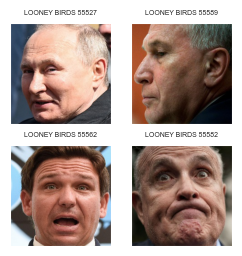

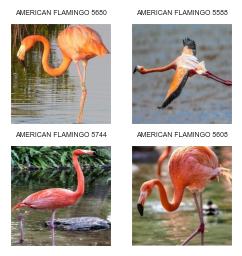

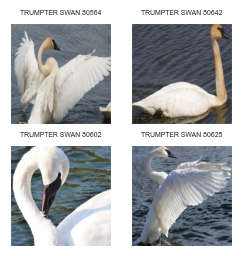

In [ ]:
birds.plot_label_images(image_df,label='LOONEY BIRDS',N=4,n_cols=2,fig_width=2.5)
birds.plot_label_images(image_df,label='AMERICAN FLAMINGO',N=4,n_cols=2,fig_width=2.5)
birds.plot_label_images(image_df,label='TRUMPTER SWAN',N=4,n_cols=2,fig_width=2.5)

# anomaly detection

In [ ]:
pred_proba_train = np.sort(obj_dic_stack['train']['pred_proba'],axis=1)
pred_proba_other = np.sort(others_obj_dic['pred_proba'],axis=1)



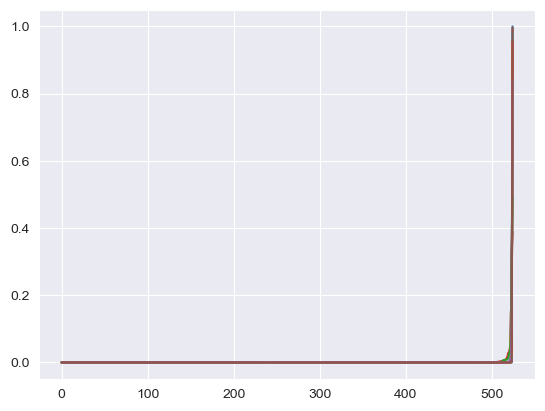

In [ ]:
plt.plot(pred_proba_other.T)

(0.0, 1.0)

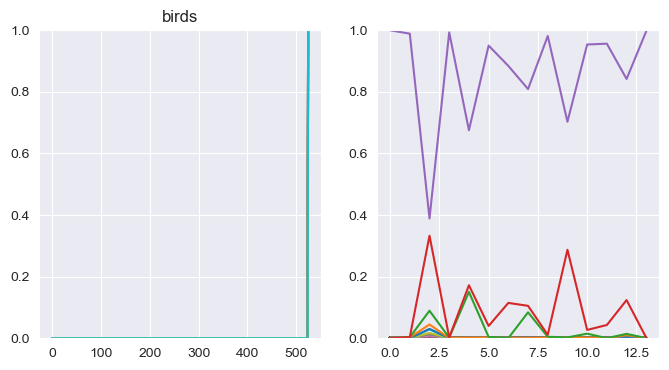

In [ ]:
birds_inx = np.random.randint(1, 3001, size=10)
others_inx = np.arange(-1,-11,-1)

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
for idx in birds_inx:
    plt.plot(pred_proba_train[idx,:])
plt.title('birds')
plt.ylim([0,1])

plt.subplot(1,2,2)
plt.plot(pred_proba_other[:])
# for idx in others_inx:
#     plt.plot(pred_proba_other[:])
# plt.title('none-birds')
plt.ylim([0,1])


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


isf = IsolationForest(contamination=0.01)
isf.fit(pred_proba_train)

is_not_bird = np.zeros(pred_proba.shape[0], dtype=bool)
for idx in range(pred_proba.shape[0]):
    is_not_bird[idx] = (isf.predict(pred_proba[idx,:].reshape(1,-1))==-1)

ind_vec = np.where(is_not_bird)[0]


In [ ]:
ind_vec
none_bird_idx = list(test_obj_dic['df'].index[ind_vec])

In [ ]:
test_obj_dic['df'].loc[87166]

In [ ]:
x_values = np.arange(1, 101)
selected_rows = ind_vec
for row_idx in selected_rows:
    line_values = pred_proba[row_idx, :]
    plt.plot(line_values, label=f'Row {row_idx}')

plt.legend(none_bird_idx)

birds.plot_images(test_obj_dic['df'],idx=test_obj_dic['df'].iloc[np.where(is_not_bird)].index)

# ☀️Grad-Cam Visualization

<div style="background-color:#fff1cc; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em"><b>Grad-CAM (Gradient-weighted Class Activation Mapping)</b> is a technique used to visualize the regions of an input image that were most relevant for a neural network's prediction. It allows you to see which regions of the image the model focused on while making its prediction. Grad-CAM is a modification of the CAM technique that extends the latter to any model that uses a convolutional neural network (CNN) as its underlying architecture.</p>
</div>

In [ ]:
from tensorflow.keras.models import Model



def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model


    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])

    with tf.GradientTape() as tape:
  # cast the image tensor to a float-32 data type, pass the
  # image through the gradient model, and grab the loss
  # associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]

		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads

		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))

		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):

    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.


    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return superimposed_img_rgb

In [ ]:
from random import shuffle
from tqdm import tqdm


def label_image_one_hot_encoder(img):
  ## Helper for process_data
  label = img.split('_')[0]
  if label == 'cat': return 0
  elif label == 'dog': return 1


def process_data(image_list, DATA_FOLDER, IMG_SIZE):
  ## Helper for manual_pre_process
  ## Creates an array of images, labels, and file path
  ## Shuffles the array before returning
  data_df = []
  for img in tqdm(image_list):
    path = os.path.join(DATA_FOLDER, img)
    label = label_image_one_hot_encoder(img)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    data_df.append([np.array(img), np.array(label), path])
  shuffle(data_df)
  return data_df


def manual_pre_process(dir, IMG_SIZE):
  '''
  Creates an array of images, labels, and files from a directory of image files

  Args:
    dir: string, folder name
    IMG_SIZE: int, image height and width

  Returns
    X: (n x IMG_SIZE x IMG_SIZE) numpy array of images
    y: (n,) numpy array of labels
    files: (n,) numpy array of files

  '''
  image_lst = os.listdir(dir)
  data_df = process_data(image_lst, dir, IMG_SIZE)
  X = np.array([i[0] for i in data_df]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  y = np.array([i[1] for i in data_df])
  files = np.array([i[2] for i in data_df])
  return X, y, files

val_imgs = './data/test/ABBOTTS BABBLER'
class_info = birds.load_var('labels_dic.pkl')
X, y, files = manual_pre_process(val_imgs, 224)

img = X[0]
label = y[0]
path = files[0]

In [ ]:
layer_name = 'top_conv'
img_array = np.expand_dims(img, axis=0)
eps=1e-8
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)

In [ ]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
plt.tight_layout()


In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
obj_dic = val_obj_dic
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})
random_index = np.random.randint(0, len(obj_dic['df']) - 1, 15)

for i, ax in enumerate(axes.flat):
    img_path = obj_dic['df'].Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    # ax.set_title(f"True: {obj_dic['df'].label.iloc[random_index[i]]}\nPredicted: {obj_dic['df'].predicted_label.iloc[random_index[i]]}")
plt.tight_layout()
plt.show()

***

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
        <p style="padding: 10px;
              color:white;">
            Thanks for viewing my work. If you like it, consider sharing it to others or give feedback to improve the notebook. Have a beautiful day my friend.
        </p>
    </div>

<center><img src='https://media4.giphy.com/media/M9gbBd9nbDrOTu1Mqx/giphy.gif?cid=790b7611704aa2ca4e403287801480a6c753abf45f3e6242&rid=giphy.gif&ct=s'
     height=30px width=160px /></center>